<a href="https://colab.research.google.com/github/Fedolodic/all-lex-text/blob/main/LexGPT_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a GPT

Companion notebook to the [Zero To Hero](https://karpathy.ai/zero-to-hero.html) video on GPT.

Assigning all lext text to the text variable.

In [1]:
# read dataset in directory to train on
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

We're working with roughly 1 million characters

In [2]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1050695


In [3]:
# let's look at the first 1000 characters
print(text[:1000])

As part of MIT course 6S099, Artificial General Intelligence,
I've gotten the chance to sit down with Max Tegmark.
He is a professor here at MIT.
He's a physicist, spent a large part of his career
studying the mysteries of our cosmological universe.
But he's also studied and delved into the beneficial
possibilities and the existential risks
of artificial intelligence.
Amongst many other things, he is the cofounder
of the Future of Life Institute, author of two books,
both of which I highly recommend.
First, Our Mathematical Universe.
Second is Life 3.0.
He's truly an out of the box thinker and a fun personality,
so I really enjoy talking to him.
If you'd like to see more of these videos in the future,
please subscribe and also click the little bell icon
to make sure you don't miss any videos.
Also, Twitter, LinkedIn, agi.mit.edu
if you wanna watch other lectures
or conversations like this one.
Better yet, go read Max's book, Life 3.0.
Chapter seven on goals is my favorite.
It's really 

In [4]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 $%&'+,.0123456789?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzéö–…
76


In [5]:
# create a mapping from characters to integers
# mapping is created using dictionary comprehension, which is a compact way of creating dictionaries using a loop.
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# examples of using our encoder/decoder on arbitarty text
print(encode("hii there"))
print(decode(encode("hii there")))

[53, 54, 54, 1, 65, 53, 50, 63, 50]
hii there


This is only one of many possible encodings, or tokenizers, but there are many other schemas that people have come up with in practice.

E.g.
* [Google's SentencePiece](https://github.com/google/sentencepiece): Sub-word unit-level tokenizer
* [OpenAI's tiktoken](https://github.com/openai/tiktoken): Byte-Pair Encoding (BPE) tokenizer
  * 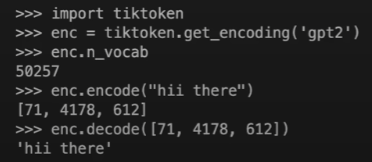
  * 50K tokens compared to 76

In practice, people typically use sub-word encodings.

Encode all of lex text

In [6]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long) # torch.long in an integer data type in PyTorch. Used because this data type is capable of storing integers with a large range than other data types
print(data.shape, data.dtype) # the shape property of the tensor shows it's dimensions
print(data[:1000]) # the 1000 characters we looked at earlier we'll give to the GPT looks like this

torch.Size([1050695]) torch.int64
tensor([20, 64,  1, 61, 46, 63, 65,  1, 60, 51,  1, 32, 28, 39,  1, 48, 60, 66,
        63, 64, 50,  1, 15, 38,  9, 18, 18,  7,  1, 20, 63, 65, 54, 51, 54, 48,
        54, 46, 57,  1, 26, 50, 59, 50, 63, 46, 57,  1, 28, 59, 65, 50, 57, 57,
        54, 52, 50, 59, 48, 50,  7,  0, 28,  5, 67, 50,  1, 52, 60, 65, 65, 50,
        59,  1, 65, 53, 50,  1, 48, 53, 46, 59, 48, 50,  1, 65, 60,  1, 64, 54,
        65,  1, 49, 60, 68, 59,  1, 68, 54, 65, 53,  1, 32, 46, 69,  1, 39, 50,
        52, 58, 46, 63, 56,  8,  0, 27, 50,  1, 54, 64,  1, 46,  1, 61, 63, 60,
        51, 50, 64, 64, 60, 63,  1, 53, 50, 63, 50,  1, 46, 65,  1, 32, 28, 39,
         8,  0, 27, 50,  5, 64,  1, 46,  1, 61, 53, 70, 64, 54, 48, 54, 64, 65,
         7,  1, 64, 61, 50, 59, 65,  1, 46,  1, 57, 46, 63, 52, 50,  1, 61, 46,
        63, 65,  1, 60, 51,  1, 53, 54, 64,  1, 48, 46, 63, 50, 50, 63,  0, 64,
        65, 66, 49, 70, 54, 59, 52,  1, 65, 53, 50,  1, 58, 70, 64, 65, 50, 63,
      

In [7]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Now it's time to give the integer sequences into the Transformer so that it can train and learn those patterns

Note: We're not going to feed the entire text into the Transformer all at once. That would be computationally very expensive and prohibitive. Instead, we're going to sample random little chunks out of the training set and train them, chunks at a time. These chunks will have a max length. The max length here is called block size.

Sometimes block size will be called context length in other algorithms.

In [9]:
block_size = 8
train_data[:block_size+1]

tensor([20, 64,  1, 61, 46, 63, 65,  1, 60])

When we sample sample a chunk of data like this, in our case the first 9 characters in the sequence in the training set, there are actually multiple examples packed into this sample. That is to say, when we plug the sample into a Transformer, we're going to simultaneously train it to make a prediction at every one of these positions.

In the chunk of 9 characters, there's actually 8 individual exmaples packed in there.

E.g. 
* In the context of 20, 64 likely comes next.
* In the context of 20 and 64, 1 likely comes next.
* In the context of 20, 64, and 1, 61 likely comes next.
* Etc.

This next chunk of code actually illustrates this idea:

In [11]:
x = train_data[:block_size] # x are the inputs to the Transformer, it will be the first block size characters
y = train_data[1:block_size+1] # y is the next block size characters. It's the target for each position in the input
examples = 0
# Iterate over the entire block size of 8
for t in range(block_size):
    context = x[:t+1] # The context is defined as the first t+1 characters of x, where t is the current iteration
    target = y[t] # The target for each iteration is defined as the t-th character of y
    print(f"when input is {context} the target is: {target}")
    examples += 1
print(f"number of examples: {examples}")

when input is tensor([20]) the target is: 64
when input is tensor([20, 64]) the target is: 1
when input is tensor([20, 64,  1]) the target is: 61
when input is tensor([20, 64,  1, 61]) the target is: 46
when input is tensor([20, 64,  1, 61, 46]) the target is: 63
when input is tensor([20, 64,  1, 61, 46, 63]) the target is: 65
when input is tensor([20, 64,  1, 61, 46, 63, 65]) the target is: 1
when input is tensor([20, 64,  1, 61, 46, 63, 65,  1]) the target is: 60
number of examples: 8


Why train a Transformer model like this? 

We want to make the Transformer Network be "used to" (so to speak) seeing contexts all the way from as little as one 1, all the way to block size. This will be useful later, during inference, because while we're sampling we can start sampling the generation with as little as 1 character of context, and the Transformer will know how to predict the next character.

So we've looked at the time dimension of the tensors that are going to be feeding into the Transformer, but there's one more dimension to care about and that's the batch dimension.

So every time we feed data into a Transformer, we're going to have many batches of multiple chunks of text that are stacked up in a single tensor. This is done for efficiency, just so that we can keep the GPUs busy because they are very good at parallel processing of data.

Note: These chunks are processed completely independently, meaning they don't talk to each other.

In [12]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[46, 58, 50,  0, 47, 50, 46, 66],
        [46, 65,  1, 70, 60, 66,  1, 58],
        [63,  1, 61, 50, 60, 61, 57, 50],
        [ 1, 57, 54, 65, 50, 63, 46, 65]])
targets:
torch.Size([4, 8])
tensor([[58, 50,  0, 47, 50, 46, 66, 65],
        [65,  1, 70, 60, 66,  1, 58, 54],
        [ 1, 61, 50, 60, 61, 57, 50,  1],
        [57, 54, 65, 50, 63, 46, 65, 66]])
----
when input is [46] the target: 58
when input is [46, 58] the target: 50
when input is [46, 58, 50] the target: 0
when input is [46, 58, 50, 0] the target: 47
when input is [46, 58, 50, 0, 47] the target: 50
when input is [46, 58, 50, 0, 47, 50] the target: 46
when input is [46, 58, 50, 0, 47, 50, 46] the target: 66
when input is [46, 58, 50, 0, 47, 50, 46, 66] the target: 65
when input is [46] the target: 65
when input is [46, 65] the target: 1
when input is [46, 65, 1] the target: 70
when input is [46, 65, 1, 70] the target: 60
when input is [46, 65, 1, 70, 60] the target: 66
when input is [46,

In [ ]:
print(xb) # our input to the transformer

tensor([[46, 58, 50,  0, 47, 50, 46, 66],
        [46, 65,  1, 70, 60, 66,  1, 58],
        [63,  1, 61, 50, 60, 61, 57, 50],
        [ 1, 57, 54, 65, 50, 63, 46, 65]])


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 76])
tensor(4.7052, grad_fn=<NllLossBackward0>)

6dZ2NJ&jWoOfzFNOxAZLD,
LOBEgaeedKryx…j&PzBVdUDweY&'oOU,févNqwSg.BtqAsRoU4n6Yxeg3fö9bwv5YD+8Erug6wVC,


In [ ]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [ ]:
batch_size = 32
for steps in range(100): # increase number of steps for good results... 
    
    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


4.706178188323975


In [ ]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


oajDb …phizdh+YsRXcOXHv q.l,zXHj&?MBJ5 zI8aHV1.eyPJOai8?cIfzAYKiv9$f1J1qU,&T…öNZézPM–e'he45eco2'.lSj$xlMlyvqjZCx'eIsf%K?OIXBPWxlcGbzsHzo2 lxl6RXVNHT4p
PxJjAp,öC&7jcjDbmDl8W6&?0I925y…jtBkUWYSv.lOööL–Y…jqZT0péxiVvqoyVMoLaöLj'V$pz…jdjZkVr'BrU6'+HG7ZLbbD2XxstH%3öCX%+5C9T71p0B?Gk2eWq%Wcz%+hF8SgGöTöYIrEneYyxl%BVHIDF8Cg.lcpY0pz4ve%Hj5edxAi2tW x8jX$kU?B?tVd6YbifBVx?éN1éqOR Ezhö59y,
iRJIXBVY0oL1O&?aoLfV&OkRfyNJs7RxK.BYY––tSöézo40Yh wGyEZ6OwN%5pb1S.ksQZM3fzy,MMtS2520Br.OQé9e
Ru%es…?Wf…X2$27j1e+gA6PNEZl–Jx


## The mathematical trick in self-attention

In [ ]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# consider the following toy example:

torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

In [ ]:
# We want x[b,t] = mean_{i<=t} x[b,i]
xbow = torch.zeros((B,T,C))
for b in range(B):
    for t in range(T):
        xprev = x[b,:t+1] # (t,C)
        xbow[b,t] = torch.mean(xprev, 0)


In [ ]:
# version 2: using matrix multiply for a weighted aggregation
wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)
torch.allclose(xbow, xbow2)

True

In [ ]:
# version 3: use Softmax
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)


True

In [ ]:
# version 4: self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [ ]:
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [ ]:
k.var()

tensor(1.0449)

In [ ]:
q.var()

tensor(1.0700)

In [ ]:
wei.var()

tensor(1.0918)

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [ ]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d)
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [ ]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [ ]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

In [ ]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>



### Full finished code, for reference

You may want to refer directly to the git repo instead though.

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.211148 M parameters
step 0: train loss 4.5327, val loss 4.5323
step 100: train loss 2.5735, val loss 2.5740
step 200: train loss 2.4569, val loss 2.4490
step 300: train loss 2.3375, val loss 2.3442
step 400: train loss 2.2428, val loss 2.2284
step 500: train loss 2.1488, val loss 2.1518
step 600: train loss 2.0861, val loss 2.0801
step 700: train loss 2.0093, val loss 2.0039
step 800: train loss 1.9684, val loss 1.9547
step 900: train loss 1.9003, val loss 1.9104
step 1000: train loss 1.8531, val loss 1.8716
step 1100: train loss 1.8384, val loss 1.8541
step 1200: train loss 1.8098, val loss 1.8221
step 1300: train loss 1.7880, val loss 1.7953
step 1400: train loss 1.7334, val loss 1.7590
step 1500: train loss 1.7285, val loss 1.7540
step 1600: train loss 1.6977, val loss 1.7282
step 1700: train loss 1.6988, val loss 1.7202
step 1800: train loss 1.6694, val loss 1.7010
step 1900: train loss 1.6458, val loss 1.6785
step 2000: train loss 1.6319, val loss 1.6743
step 2100: train loss 1.